**IFSP - Campus Campinas** <br>
**Pós-graduação em Ciência de Dados** <br>
**Disciplina D3TOP/2023 – Tópicos em Ciência de Dados** <br>

**Projeto em Grupo - Parte 2**

#### Sprint 6 (AWS) - v 2.6 (AWS) 
- limpeza inicial de linhas com NaN no campo 'Texto'
- pre-processamento com NTLK
- feature extraction com pipelines e um ColumnTransformer
  * Para o pipeline de dados numéricos, o __numerical_processor__ usa um MinMaxScaler. 
  * Para o pipeline de dados de texto, o __text_processor__ usa  `CountVectorizer()` nos campos de texto.
- treinamento com LinearLearner() do SageMaker
- rodado em AWS
   

Professor: Samuel Martins (samuel.martins@ifsp.edu.br)<br>
Aluno: Swift Motoo Yaguchi - CP301665X

------

# Etapa de limpeza e pré-processamento

**Instalando bibliotecas**

In [1]:
#Upgrade dependencies
#!pip install --upgrade pip
#!pip install --upgrade scikit-learn
#!pip install --upgrade wordcloud
#!pip install --upgrade sagemaker

In [2]:
import pandas as pd
import numpy as np

##### Leitura da base de dados

In [4]:
df = pd.read_csv('PLO 2019 v3.csv', sep=';', encoding = 'latin1')
df.head(3)

,Texto,Ementa,Vereador,Data,Nota,isUtil
0,Art. I Fica denominado Praça Sandra Hitomi Ta...,DENOMINA PRAÇA SANDRA HITOMI TAKAHASHI UM SIST...,Carmo Luiz,2019,9,0
1,Art. lº Ficam proibidos a comercialização e o...,PROÍBE O COMÉRCIO E O USO DOS PRODUTOS QUE ESP...,Luiz Rossini,2019,13,0
2,Art. 1 0 Poder Executivo municipal deverá disp...,DISPÕE SOBRE O ACESSO ÀS INFORMAÇÕES A RESPEIT...,Luiz Cirilo,2019,1,1


### Etapa de limpeza e pré-processamento

In [5]:
df.dtypes

Texto       object
Ementa      object
Vereador    object
Data         int64
Nota         int64
isUtil       int64
dtype: object

In [6]:
# Verificando se base de dados tem valores ausentes
df.isna().sum()

Texto       235
Ementa        0
Vereador    235
Data          0
Nota          0
isUtil        0
dtype: int64

In [7]:
# Removendo as linhas em branco
df = df.dropna()

In [8]:
df.isna().sum()

Texto       0
Ementa      0
Vereador    0
Data        0
Nota        0
isUtil      0
dtype: int64

In [9]:
print('O tamanho do dataset é:', df.shape)

O tamanho do dataset é: (99, 6)


In [10]:
df['isUtil'].value_counts()

0    82
1    17
Name: isUtil, dtype: int64

### Processamento de texto: remoção de palavras irrelevantes e stemming
Remoção com bilioteca [nltk](https://www.nltk.org/)

In [11]:
#!pip install --upgrade nltk

In [12]:
# Install the library and functions
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Get a list of stopwords from the NLTK library
stop = stopwords.words('portuguese')

# New stopword list
# stopwords = [word for word in stop if word not in excluding]
#stopwords = [word for word in stop]
# Add 'Art' and 'Lei' to the stopwords list
sto = stop + ['art', 'lei']
stopwords = [word for word in sto]

In [14]:
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

In [15]:
snow = SnowballStemmer('portuguese')

Remoções:
- Substitui todos os valores ausentes por uma string vazia
- Converte o texto em letras minúsculas
- Remove espaços em branco à esquerda ou à direita
- Remove espaços e recuos extras
- Remove marcações HTML

In [16]:
import re
def process_text(texts):
    final_text_list=[]
    for sent in texts:

        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ''
        filtered_sentence=[]
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        for w in word_tokenize(sent):
            # Applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stopwords
            if(not w.isnumeric()) and (len(w)>2) and (w not in stopwords) :
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) # Final string of cleaned words
        final_text_list.append(final_string)
    return final_text_list

### Divisão dos dados para treinamento, validação e teste
Dividir o conjunto de dados para treinamento (80%), validação (10%) e teste (10%).

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[['Texto', 'Ementa', 'Data', 'Nota']],
                                                  df['isUtil'],
                                                  test_size=0.20,
                                                  shuffle=True,
                                                  random_state=324
                                                  )

X_val, X_test, y_val, y_test = train_test_split(X_val,
                                                y_val,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=324)

Com o conjunto de dados dividido, a função  `process_text` definida acima em cada um dos recursos de texto nos conjuntos de treinamento, teste e validação será executada

In [18]:
print('Processand a coluna Texto')
X_train['Texto'] = process_text(X_train['Texto'].tolist())
X_val['Texto'] = process_text(X_val['Texto'].tolist())
X_test['Texto'] = process_text(X_test['Texto'].tolist())

print('Processando a coluna Ementa')
X_train['Ementa'] = process_text(X_train['Ementa'].tolist())
X_val['Ementa'] = process_text(X_val['Ementa'].tolist())
X_test['Ementa'] = process_text(X_test['Ementa'].tolist())

Processand a coluna Texto
Processando a coluna Ementa


In [19]:
X_train.head(3)

,Texto,Ementa,Data,Nota
64,fic denomin prac marcel xavi souz sistem laz q...,denomin prac marcel xavi souz sistem laz munic...,2019,9
69,part dest dat conform manifest procurador legi...,acrescent 20-a 9.953 dezembr dispõ sobr insta...,2019,11
32,câm municipal aprov prefeit municípi campin sa...,dispõ sobr revog 12.116 outubr dispõ sobr obri...,2019,2


In [21]:
!pip install --upgrade wordcloud

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 5.3 MB/s eta 0:00:0000:01


#### Word Cloud

Text(0.5, 1.0, 'Word Cloud : X_train["Texto"]')

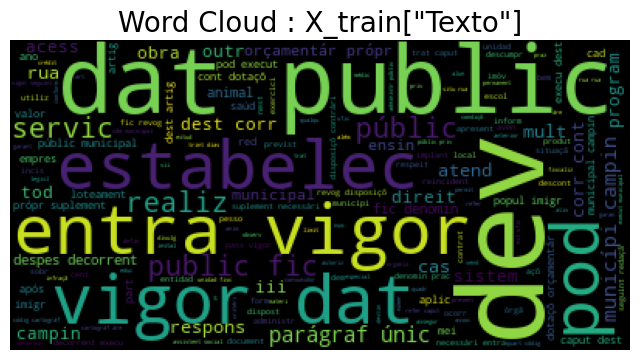

In [22]:
from wordcloud import WordCloud

# Generate a word cloud image
text = ' '.join(X_train['Texto'])
wordcloud = WordCloud().generate(text)

# Display the generated image the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud : X_train["Texto"]', fontsize=20)

In [23]:
X_val.head(3)

,Texto,Ementa,Data,Nota
65,fic estabelec ensin ofic red públic municipal ...,estabelec obrigatoriedad estabelec ensin ofic ...,2019,2
79,fic denomin prac mar souz ruiz prac quart códi...,denomin prac mar souz ruiz prac públic municíp...,2019,9
91,fic revog incis 11.111/2001 fic revog incis 11...,revog incis 11.111 dezembr dispõ sobr impost s...,2019,7


Text(0.5, 1.0, 'Word Cloud : X_val["Texto"]')

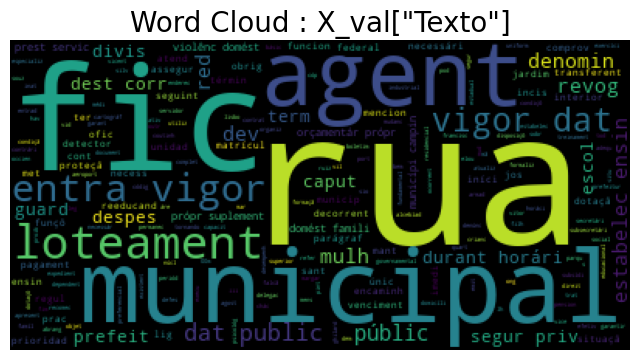

In [24]:
from wordcloud import WordCloud

# Generate a word cloud image
text = ' '.join(X_val['Texto'])
wordcloud = WordCloud().generate(text)

# Display the generated image the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud : X_val["Texto"]', fontsize=20)

In [25]:
X_test.head(3)

,Texto,Ementa,Data,Nota
39,projet ordinár pass tramit projet complement 1...,dispõ sobr criaçã bilhet únic validad dias pas...,2019,6
24,fic agênc bancár estabelec municípi campin obr...,dispõ âmbit municípi campin sobr obrigatorieda...,2019,6
61,fic órgã públic empres públic empres concessio...,dispõ sobr atend preferencial pesso fibromialg...,2019,7


Text(0.5, 1.0, 'Word Cloud : X_test["Texto"]')

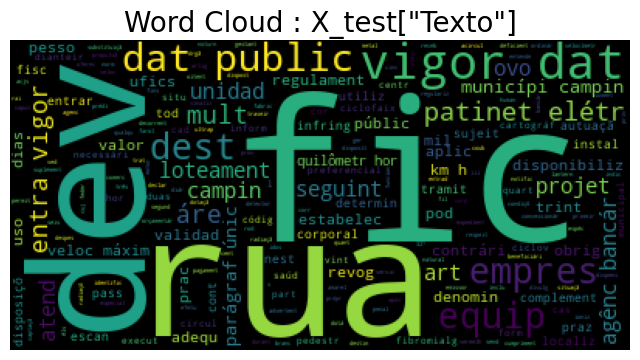

In [26]:
from wordcloud import WordCloud

# Generate a word cloud image
text = ' '.join(X_test['Texto'])
wordcloud = WordCloud().generate(text)

# Display the generated image the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud : X_test["Texto"]', fontsize=20)

### Processamento de dados com pipelines e um ColumnTransformer
Como temos dados numéricos e de texto, definimos os seguintes pipelines:
* Para o pipeline de dados numéricos, o __numerical_processor__ usa um MinMaxScaler. 
* Para o pipeline de dados de texto, o __text_processor__ usa  `CountVectorizer()` nos campos de texto.
As preparações seletivas dos recursos do conjunto de dados são reunidas em um ColumnTransformer coletivo, que será usado em um pipeline com um estimador. 

In [27]:
# Grab model features/inputs and target/output
numerical_features = ['Data', 'Nota']
text_features = ['Texto', 'Ementa']

model_features = numerical_features + text_features
model_target = 'isUtil'

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### COLUMN_TRANSFORMER ###
# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) 
                                ])
# Preprocess 1st text feature (larger vocabulary)
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=250))
                            ])

# Preprocess 2nd text feature 
text_precessor_1 = Pipeline([
    ('text_vect_1', CountVectorizer(binary=True, max_features=50))
                            ])

# Combine all data preprocessors from above 
# For each processor/step is specified a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('text_pre_0', text_processor_0, text_features[0]),
    ('text_pre_1', text_precessor_1, text_features[1])
                                      ]) 

### DATA PREPROCESSING ###
print('Datasets shapes before processing: ', X_train.shape, X_val.shape, X_test.shape)

X_train = data_preprocessor.fit_transform(X_train).toarray()
X_val = data_preprocessor.transform(X_val).toarray()
X_test = data_preprocessor.transform(X_test).toarray()

print('Datasets shapes after processing: ', X_train.shape, X_val.shape, X_test.shape)

Datasets shapes before processing:  (79, 4) (10, 4) (10, 4)
Datasets shapes after processing:  (79, 302) (10, 302) (10, 302)


Observa-se que o número de recursos nos conjuntos de dados passou de 4 para 302.

In [29]:
# salvando dados transformados
np.save('X_train_transformado.npy', X_train)
np.save('X_val_transformado.npy', X_val)
np.save('X_test_transformado.npy', X_test)

# recuperando dados transformados, se precisar
#X_train = np.load('X_train_transformado.npy')
#X_val = np.load('X_val_transformado.npy')
#X_test = np.load('X_test_transformado.npy)

### Treinamento de um classificador com um algoritmo integrado ao AWS SageMaker
Utilizamos o algoritmo  `LinearLearner()` do SageMaker com as seguintes opções:
* __Permissions -__  `role` está configurado como a role do AWS Identity and Access Management (IAM) do ambiente atual.
* __Compute power -__ Usaremos os parâmetros  `train_instance_count` = `1` e  `train_instance_type` = `ml.m4.xlarge`. 
* __Model type -__  `predictor_type` está configurado como __`binary_classifier`__, porque estamos com um problema de classificação binária. 

In [30]:
import sagemaker

# Call the LinearLearner estimator object
linear_classifier = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                           instance_count=1,
                                           instance_type='ml.m4.xlarge',
                                           predictor_type='binary_classifier')

Para definir as partes de treinamento, validação e teste do estimador, usaremos a função  `record_set()` do  `binary_estimator`. 

In [31]:
train_records = linear_classifier.record_set(X_train.astype('float32'),
                                            y_train.values.astype('float32'),
                                            channel='train')
val_records = linear_classifier.record_set(X_val.astype('float32'),
                                          y_val.values.astype('float32'),
                                          channel='validation')
test_records = linear_classifier.record_set(X_test.astype('float32'),
                                           y_test.values.astype('float32'),
                                           channel='test')

Com a função  `fit()` aplicamos uma versão distribuída do algoritmo Stochastic Gradient Descent (SGD). __Esse processo leva cerca de 3 a 4 minutos em uma instância ml.m4.xlarge do AWS Sagemaker.__

In [32]:
linear_classifier.fit([train_records,
                       val_records,
                       test_records],
                       logs=False)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-06-04-06-04-10-526



2023-06-04 06:04:11 Starting - Starting the training job...
2023-06-04 06:04:36 Starting - Preparing the instances for training...............
2023-06-04 06:05:54 Downloading - Downloading input data.....
2023-06-04 06:06:24 Training - Downloading the training image.............
2023-06-04 06:07:35 Training - Training image download completed. Training in progress......
2023-06-04 06:08:05 Uploading - Uploading generated training model.
2023-06-04 06:08:16 Completed - Training job completed


### Avaliação do modelo

Usaremos a análise do SageMaker para ver métricas de performance do conjunto de testes. 

O linear learner apresenta métricas que são calculadas durante o treinamento. É possível usar essas métricas ao ajustar o modelo. As métricas disponíveis para o conjunto de validação são:

- objective_loss - No caso de um problema de classificação binária, será o valor médio da perda logística para cada época
- binary_classification_accuracy - A precisão do modelo final no conjunto de dados, ou seja, quantas previsões o modelo acertou
- precision - Quantifica o número de previsões de classes positivas que são de fato positivas
- recall - Quantifica o número de previsões de classes positivas
- binary_f_beta - A média harmônica das métricas de precisão e recall

Neste exemplo, é importante observar quantas previsões estavam corretas. O uso da métrica **binary_classification_accuracy** é apropriado.

In [33]:
sagemaker.analytics.TrainingJobAnalytics(linear_classifier._current_job_name, 
                                         metric_names = ['test:binary_classification_accuracy']
                                        ).dataframe()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


,timestamp,metric_name,value
0,0.0,test:binary_classification_accuracy,0.9


In [34]:
sagemaker.analytics.TrainingJobAnalytics(linear_classifier._current_job_name).dataframe()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


,timestamp,metric_name,value
0,0.0,train:progress,6.666667
1,60.0,train:progress,80.000000
2,0.0,test:binary_f_beta,0.666667
3,0.0,test:recall,1.000000
4,0.0,train:objective_loss,0.721147
5,60.0,train:objective_loss,0.313187
6,0.0,test:objective_loss,0.544470
7,0.0,validation:binary_f_beta,0.666667
8,0.0,validation:objective_loss,0.810043
9,60.0,validation:objective_loss,0.642697


Podemos ver valor de acurácia aproximado de 0,90

## Implementação do modelo em um endpoint

Aqui vamos fazer deployment do modelo para usar esse modelo em um ambiente de produção. 
Para implementar o modelo, é possível usar diferentes tipos de instância, como: _ml.t2.medium_, _ml.c4.xlarge_), entre outras. 
__Esse processo levará de 7 a 8 minutos.__

In [35]:

linear_classifier_predictor = linear_classifier.deploy(initial_instance_count = 1,
                                                       instance_type = 'ml.c5.large'
                                                      )

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2023-06-04-06-09-42-783
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-06-04-06-09-42-783
INFO:sagemaker:Creating endpoint with name linear-learner-2023-06-04-06-09-42-783


----------!

### Teste do endpoint
Agora que o endpoint está implementado, testaremos envio de dados de teste localmente e veremos previsões dos dados.

In [36]:
import numpy as np

# Get test data in batch size of 1 and make predictions.
prediction_batches = [linear_classifier_predictor.predict(batch)
                      for batch in np.array_split(X_test.astype('float32'), 1)
                     ]

# Get a list of predictions
print([pred.label['score'].float32_tensor.values[0] for pred in prediction_batches[0]])
print([pred.label['predicted_label'].float32_tensor.values[0] for pred in prediction_batches[0]])

[0.897745668888092, 0.0004212151688989252, 1.9293255881791538e-09, 6.039728032192215e-05, 0.000519416993483901, 0.043039195239543915, 4.9148966354550794e-05, 0.00036963788443244994, 0.00010606787691358477, 0.017091860994696617]
[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [37]:
# Get test data for one data and make prediction.
prediction = [linear_classifier_predictor.predict(X_test.astype('float32')[1])]

# Get a list of predictions
print([pred.label['score'].float32_tensor.values[0] for pred in prediction[0]])
print([pred.label['predicted_label'].float32_tensor.values[0] for pred in prediction[0]])

[0.0004212151688989252]
[0.0]


In [38]:
prediction = [linear_classifier_predictor.predict(X_test.astype('float32')[1])]
print([pred.label['score'] for pred in prediction[0]])
print([pred.label['predicted_label'] for pred in prediction[0]])

[float32_tensor {
  values: 0.0004212151688989252
}
]
[float32_tensor {
  values: 0.0
}
]


In [41]:
test_data = X_test.astype('float32')[0]

In [42]:
prediction = [linear_classifier_predictor.predict(test_data)]

# Get a list of predictions
print([pred.label['score'].float32_tensor.values[0] for pred in prediction[0]])
print([pred.label['predicted_label'].float32_tensor.values[0] for pred in prediction[0]])

[0.897745668888092]
[1.0]


## Remoção de artefatos do modelo

Após teste concluído, é importante excluir o endpoint, para não gerar custo de utilização de recursos AWS.


In [85]:
linear_classifier_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-06-02-16-01-04-598
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-06-02-16-01-04-598
